## ***Exploratory Data Analysis For StackOverflow Tag Prediction***

***Using EDA, help Stack Overflow implement the following features in its web application:***


*   When a user raises a question with a data science tag ('python', 'r','matlab', 'sas', 'excel', 'sql'), then Stack Overflow sends the notification to the relevant users.

*   When a user provides a data science tag ('python', 'r', 'matlab', 'sas', 'excel', 'sql') to their question, then Stack Overflow should come up with the expected approximate time to get it answered.

*   While a user raises a question, Stack Overflow wants to provide some suggestions to the users to get their queries answered quickly.

***Load and understand your data***
- The data consists of 4 tables which are loaded separately with appropriate formatting


In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### ***Questions***

In [2]:
df_Question = pd.read_csv('https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Questions.csv',encoding='latin_1')
df_Question.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


##### We can see that Title is in plain text, while Body is in HTML format, which requires a lot of data cleansing before it is in a useful format. Also note that punctuations can be meaningful in this problem, e.g. ASP.NET, C#, etc, so we need to be careful not to remove them during data cleansing.

In [3]:
df_Question.info()
df_Question.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


,Id,OwnerUserId,Score
count,1.264216e+06,1.249762e+06,1.264216e+06
mean,2.132745e+07,2.155177e+06,1.781537e+00
std,1.151445e+07,1.801265e+06,1.366389e+01
min,8.000000e+01,1.000000e+00,-7.300000e+01
25%,1.142598e+07,6.589110e+05,0.000000e+00
50%,2.172542e+07,1.611830e+06,0.000000e+00
75%,3.154542e+07,3.353792e+06,1.000000e+00
max,4.014338e+07,7.046594e+06,5.190000e+03


In [4]:
df_Question.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [5]:
# summarising number of missing values in each column
null_cols_Questions = df_Question.isnull().sum()
null_cols_Questions

Id                    0
OwnerUserId       14454
CreationDate          0
ClosedDate      1208257
Score                 0
Title                 0
Body                  0
dtype: int64

In [6]:
# viewing percentage of missing values in each column before drop operation

null_cols_Questions = df_Question.isnull().sum()/len(df_Question.index)*100

# List of Columns where NA values are more than 50%
null_cols_Questions = null_cols_Questions[null_cols_Questions.values>50]
len(null_cols_Questions)

1

In [7]:
#dropping the columns with more than 50% nulls
print("Shape of Dataframe before drop",df_Question.shape)
null_cols_Questions = list(null_cols_Questions.index)
df_Question.drop(labels=null_cols_Questions,axis=1,inplace=True)
print("Shape of Dataframe after drop",df_Question.shape)

Shape of Dataframe before drop (1264216, 7)
Shape of Dataframe after drop (1264216, 6)


In [8]:
#Requester Id , i.e., OwnerUserId can be removed
df_Question.drop(labels='OwnerUserId',axis=1,inplace=True)

In [9]:
df_Question.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Id            1264216 non-null  int64 
 1   CreationDate  1264216 non-null  object
 2   Score         1264216 non-null  int64 
 3   Title         1264216 non-null  object
 4   Body          1264216 non-null  object
dtypes: int64(2), object(3)
memory usage: 48.2+ MB


### ***Answers***

In [10]:
df_Answers = pd.read_csv('https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Answers.csv',encoding='latin_1')
df_Answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [11]:
df_Answers.info()
df_Answers.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014516 entries, 0 to 2014515
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Id            int64  
 1   OwnerUserId   float64
 2   CreationDate  object 
 3   ParentId      int64  
 4   Score         int64  
 5   Body          object 
dtypes: float64(1), int64(3), object(2)
memory usage: 92.2+ MB


,Id,OwnerUserId,ParentId,Score
count,2.014516e+06,2.001316e+06,2.014516e+06,2.014516e+06
mean,1.915490e+07,1.487613e+06,1.808390e+07,2.480563e+00
std,1.168713e+07,1.549051e+06,1.169152e+07,1.590938e+01
min,9.200000e+01,1.000000e+00,8.000000e+01,-4.200000e+01
25%,8.854490e+06,2.818680e+05,7.692900e+06,0.000000e+00
50%,1.866246e+07,9.546430e+05,1.712404e+07,1.000000e+00
75%,2.929756e+07,2.197072e+06,2.804977e+07,2.000000e+00
max,4.014339e+07,7.045028e+06,4.014319e+07,5.718000e+03


In [12]:
# summarising number of missing values in each column
null_cols_Answers = df_Answers.isnull().sum()
null_cols_Answers

Id                  0
OwnerUserId     13200
CreationDate        0
ParentId            0
Score               0
Body                0
dtype: int64

In [13]:
# viewing percentage of missing values in each column before drop operation

null_cols_Answers = df_Answers.isnull().sum()/len(df_Answers.index)*100

# List of Columns where NA values are more than 50%
null_cols_Answers = null_cols_Answers[null_cols_Answers.values>50]
len(null_cols_Answers)

0

In [14]:
df_Answers["OwnerUserId"] = df_Answers["OwnerUserId"].fillna(0)
null_cols_Answers = df_Answers.isnull().sum()
null_cols_Answers

Id              0
OwnerUserId     0
CreationDate    0
ParentId        0
Score           0
Body            0
dtype: int64

In [15]:
df_Answers["OwnerUserId"] = df_Answers["OwnerUserId"].astype('int64')
df_Answers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014516 entries, 0 to 2014515
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Id            int64 
 1   OwnerUserId   int64 
 2   CreationDate  object
 3   ParentId      int64 
 4   Score         int64 
 5   Body          object
dtypes: int64(4), object(2)
memory usage: 92.2+ MB


### ***Tags***

In [16]:
df_Tags = pd.read_csv('https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Tags.csv',encoding='latin_1')
df_Tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


##### Questions has a one-to-many relationship with Tags, as there is only one question ID and tag pair in each record

In [17]:
df_Tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [18]:
# summarising number of missing values in each column
null_cols_Tags = df_Tags.isnull().sum()
null_cols_Tags

Id        0
Tag    1113
dtype: int64

In [19]:
# viewing percentage of missing values in each column before drop operation

null_cols_Tags = df_Tags.isnull().sum()/len(df_Tags.index)*100

# List of Columns where NA values are more than 50%
null_cols_Tags = null_cols_Tags[null_cols_Tags.values>50]
len(null_cols_Tags)

0

In [20]:
#Impute Tag column with mode as it is categorical
df_Tags = df_Tags.fillna(df_Tags['Tag'].value_counts().index[0])
df_Tags.isnull().sum()


Id     0
Tag    0
dtype: int64


### ***Top 10 tags with most questions***

In [21]:
tag_value_counts = df_Tags["Tag"].value_counts()
top_ten_tags = tag_value_counts.head(10)
top_ten_tags

javascript    125268
java          115212
c#            101186
php            98808
android        90659
jquery         78542
python         64601
html           58976
c++            47591
ios            47009
Name: Tag, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

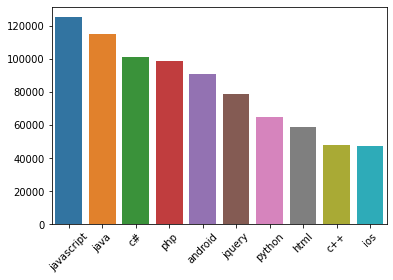

In [22]:
sns.barplot(x=top_ten_tags.index, y=top_ten_tags.values)
plt.xticks(rotation=45)

In [23]:
top_25_tags = tag_value_counts.head(25)
top_25_tags

javascript       125268
java             115212
c#               101186
php               98808
android           90659
jquery            78542
python            64601
html              58976
c++               47591
ios               47009
mysql             42464
css               42308
sql               35782
asp.net           29970
objective-c       26922
ruby-on-rails     25789
.net              24059
c                 23238
iphone            21539
angularjs         20345
arrays            19799
sql-server        18160
json              17669
ruby              17013
r                 15701
Name: Tag, dtype: int64


### ***Top 25 tags with most questions***

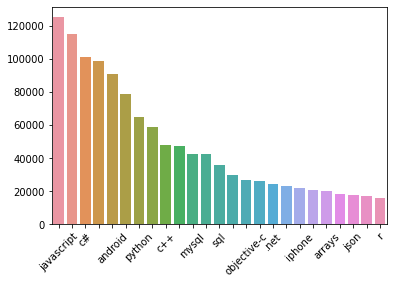

In [24]:
top_25_tags_barplot = sns.barplot(x=top_25_tags.index, y=top_25_tags.values)
for i, label in enumerate(top_25_tags_barplot.xaxis.get_ticklabels()):
    if i % 2 != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
top_25_tags_barplot

In [25]:
pd.options.display.float_format = "{:.2f}%".format
100 * tag_value_counts.head(4000).cumsum() / tag_value_counts.sum()

javascript        3.34%
java              6.41%
c#                9.11%
php              11.74%
android          14.16%
                  ...  
w3c-validation   89.94%
visible          89.94%
gpuimage         89.95%
disk             89.95%
jooq             89.95%
Name: Tag, Length: 4000, dtype: float64

In [26]:
# checking if data science tags present

ds_tags = ['python', 'r', 'matlab', 'sas', 'excel', 'sql']
df_Tags.loc[df_Tags['Tag'].isin(ds_tags)]

,Id,Tag
7,120,sql
67,1970,sql
72,2120,sql
99,2840,sql
130,4110,sql
...,...,...
3750911,40142550,sql
3750921,40142600,python
3750940,40142840,python
3750945,40142860,excel


In [27]:
df_Tags = df_Tags.loc[df_Tags['Tag'].isin(ds_tags)]


In [28]:
df_Tags.shape
df_Tags.info()
df_Tags['Tag'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133660 entries, 7 to 3750981
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      133660 non-null  int64 
 1   Tag     133660 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


python    64601
sql       35782
r         15701
excel     10384
matlab     6495
sas         697
Name: Tag, dtype: int64

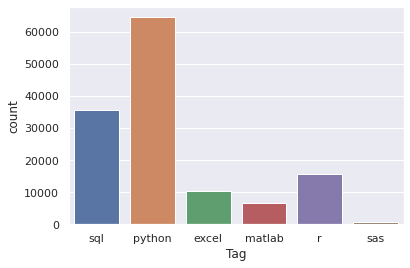

In [29]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x='Tag', data=df_Tags)

### ***Users***

In [30]:
df_Users = pd.read_csv('https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Users.csv',encoding='latin_1')
df_Users.head()

,Unnamed: 0,id,display_name,creation_date,last_access_date,reputation,up_votes,down_votes,views
0,0,26,Shawn,2008-08-01 12:18:14.52 UTC,2018-04-11 04:40:35.66 UTC,11820,565,67,3547
1,1,26,Shawn,2008-08-01 12:18:14.52 UTC,2018-04-11 04:40:35.66 UTC,11820,565,67,3547
2,2,26,Shawn,2008-08-01 12:18:14.52 UTC,2018-04-11 04:40:35.66 UTC,11820,565,67,3547
3,3,26,Shawn,2008-08-01 12:18:14.52 UTC,2018-04-11 04:40:35.66 UTC,11820,565,67,3547
4,4,26,Shawn,2008-08-01 12:18:14.52 UTC,2018-04-11 04:40:35.66 UTC,11820,565,67,3547


In [31]:
df_Users.info()
df_Users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990480 entries, 0 to 1990479
Data columns (total 9 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Unnamed: 0        int64 
 1   id                int64 
 2   display_name      object
 3   creation_date     object
 4   last_access_date  object
 5   reputation        int64 
 6   up_votes          int64 
 7   down_votes        int64 
 8   views             int64 
dtypes: int64(6), object(3)
memory usage: 136.7+ MB


,Unnamed: 0,id,reputation,up_votes,down_votes,views
count,1990480.00%,1990480.00%,1990480.00%,1990480.00%,1990480.00%,1990480.00%
mean,995239.50%,1480736.92%,45455.04%,1539.70%,821.24%,9450.82%
std,574602.23%,1543848.19%,122637.78%,3494.25%,4199.03%,78775.72%
min,0.00%,1.00%,1.00%,0.00%,0.00%,0.00%
25%,497619.75%,279761.75%,931.00%,58.00%,2.00%,109.00%
50%,995239.50%,949476.00%,5042.00%,353.00%,18.00%,529.00%
75%,1492859.25%,2183668.50%,28061.00%,1470.00%,149.00%,2675.00%
max,1990479.00%,7045028.00%,1128126.00%,100520.00%,74955.00%,1835157.00%


In [32]:
# summarising number of missing values in each column
null_cols_Users = df_Users.isnull().sum()
null_cols_Users

Unnamed: 0            0
id                    0
display_name        136
creation_date         0
last_access_date      0
reputation            0
up_votes              0
down_votes            0
views                 0
dtype: int64

In [33]:
# viewing percentage of missing values in each column before drop operation

null_cols_Users = df_Users.isnull().sum()/len(df_Users.index)*100

# List of Columns where NA values are more than 50%
null_cols_Users = null_cols_Users[null_cols_Users.values>50]
len(null_cols_Users)

0

In [34]:
#Removing other columns which are not required

drop_cols=['creation_date', 'last_access_date', 'display_name','Unnamed: 0']
df_Users.drop(labels=drop_cols,axis=1,inplace=True)
df_Users.head()

,id,reputation,up_votes,down_votes,views
0,26,11820,565,67,3547
1,26,11820,565,67,3547
2,26,11820,565,67,3547
3,26,11820,565,67,3547
4,26,11820,565,67,3547


In [35]:
# removing duplicate user ids
print("Shape of Dataframe before drop",df_Users.shape)
df_Users.drop_duplicates(subset=['id'], keep='first', inplace=True)
print("Shape of Dataframe after drop",df_Users.shape)
df_Users.head(10)

Shape of Dataframe before drop (1990480, 5)
Shape of Dataframe after drop (465460, 5)


,id,reputation,up_votes,down_votes,views
0,26,11820,565,67,3547
27,1109,116072,457,136,6905
85,364174,325,25,1,60
87,61,22779,1321,219,1731
97,20709,978,73,2,96
99,16012,19888,484,30,1823
105,12734,695,35,0,105
107,50,8525,814,50,1731
129,86,4839,1760,60,554
143,157,41717,1491,588,2102


#### Combining relevant dataframes together and dropping duplicates



**Joining Questions with Tags and Answers**

In [36]:
# standardize column names
for df in [df_Question, df_Tags,df_Answers,df_Users]:
    df.columns = df.columns.str.lower()

In [37]:
df_Question.rename(columns = {'body' : 'body_quest'}, inplace = True)

In [38]:
%%time
# group rows per question id
tags_per_question_df = df_Tags.groupby(['id'])['tag'].apply(list)

CPU times: user 2.56 s, sys: 0 ns, total: 2.56 s
Wall time: 2.57 s


In [39]:
%%time
# group rows per question id
answers_per_question_df_body = df_Answers.groupby(['parentid'])['body'].apply(list)

CPU times: user 23.1 s, sys: 0 ns, total: 23.1 s
Wall time: 23.1 s


In [40]:
%%time
# group rows per question id
answers_per_question_df_score = df_Answers.groupby(['parentid'])['score'].apply(np.sum)

CPU times: user 1min 27s, sys: 0 ns, total: 1min 27s
Wall time: 1min 27s


In [41]:
answers_per_question_df_score.head()

parentid
80     19
90     34
120     9
180    54
260    63
Name: score, dtype: int64

In [42]:
%%time
# we are only interested in text column from 'df_answers'
df =  df_Question.merge(answers_per_question_df_score.to_frame(), left_on="id",right_on='parentid')

CPU times: user 588 ms, sys: 0 ns, total: 588 ms
Wall time: 589 ms


In [43]:
df.head()

,id,creationdate,score_x,title,body_quest,score_y
0,80,2008-08-01T13:57:07Z,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,19
1,90,2008-08-01T14:41:24Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,34
2,120,2008-08-01T15:50:08Z,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,9
3,180,2008-08-01T18:42:19Z,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,54
4,260,2008-08-01T23:22:08Z,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,63


In [44]:
df.rename(columns = {'score_x' : 'score_quest', 'score_y' : 'score_ans'}, inplace = True)


In [45]:
%%time
# we are only interested in text column from 'df_answers'
df =  df.merge(answers_per_question_df_body.to_frame(), left_on="id",right_on='parentid')

CPU times: user 443 ms, sys: 0 ns, total: 443 ms
Wall time: 445 ms


In [46]:
%%time
# we are only interested in text column from 'df_tags'
df =  df.merge(tags_per_question_df.to_frame(), on='id')

CPU times: user 275 ms, sys: 0 ns, total: 275 ms
Wall time: 275 ms


In [47]:
df.head(10)

,id,creationdate,score_quest,title,body_quest,score_ans,body,tag
0,120,2008-08-01T15:50:08Z,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,9,[<p>The Jeff Prosise version from MSDN magazin...,[sql]
1,1970,2008-08-05T06:39:31Z,10,What language do you use for PostgreSQL trigge...,<p>PostgreSQL is interesting in that it suppor...,22,[<p>When I wrote my first trigger it was in Pe...,[sql]
2,2120,2008-08-05T11:49:11Z,77,Convert HashBytes to VarChar,<p>I want to get the MD5 Hash of a string valu...,191,[<p>I have found the solution else where:</p>\...,[sql]
3,2840,2008-08-05T20:57:00Z,32,Paging SQL Server 2005 Results,<p>How do I page results in SQL Server 2005?</...,52,[<p>You can use <code>the Row_Number()</code> ...,[sql]
4,4110,2008-08-06T23:19:50Z,7,What program can I use to generate diagrams of...,<p>I've been tasked with redesigning part of a...,5,[<P>If you are talking about MS SQL Server tab...,[sql]
5,6340,2008-08-08T20:07:43Z,10,Multiple foreign keys?,<p>I've got a table that is supposed to track ...,7,[<p>You defined the primary key twice. Try:</p...,[sql]
6,10190,2008-08-13T18:38:02Z,10,How to return a page of results from SQL?,<p>Many applications have grids that display d...,23,"[<p>On MS SQL Server 2005 and above, <a href=""...",[sql]
7,11060,2008-08-14T13:59:21Z,18,How should I unit test a code-generator?,<p>This is a difficult and open-ended question...,12,[<p>I started writing up a summary of my exper...,[python]
8,13540,2008-08-17T06:48:50Z,83,Insert Update stored proc on SQL Server,<p>I've written a stored proc that will do an ...,117,"[<p>Your assumption is right, this is the opti...",[sql]
9,17250,2008-08-20T00:16:40Z,24,Create an encrypted ZIP file in Python,<p>I'm creating an ZIP file with ZipFile in Py...,16,"[<p>You can use the <a href=""http://www.chilka...",[python]


In [48]:
df.rename(columns = {'body' : 'body_ans'}, inplace = True)

In [49]:
df['tags'] = [' '.join(map(str, l)) for l in df['tag']]
df.drop(labels='tag',axis=1,inplace=True)
df["tag_count"] = df["tags"].apply(lambda text: len(text.split(" ")))

In [50]:
df.sort_values(by='tag_count', ascending=False)

,id,creationdate,score_quest,title,body_quest,score_ans,body_ans,tags,tag_count
43049,18614630,2013-09-04T13:02:47Z,0,Looking for an algorithm to count the number o...,<p>I need your help in constructing an algorit...,1,[<p>Look at the Matlab function <code>perms</c...,python r matlab,3
16762,8457110,2011-12-10T14:15:41Z,3,How to vectorize the evaluation of bilinear & ...,<p>Given any <em>n</em> x <em>n</em> matrix of...,4,[<p>It's not entirely clear what you're trying...,python r matlab,3
47866,20151800,2013-11-22T18:19:20Z,1,Trying to replace a value in a sheet.row list ...,<p>I imported an excel spreadsheet and I am tr...,4,[<p>xlrd isn't really set up to edit the sprea...,python sql excel,3
80655,29918720,2015-04-28T11:53:11Z,1,Calculating Other records dissimilarity measur...,<p>Say I define dissimilarity/similarity of a ...,0,[<p>Here is a generalized way by converting to...,sql r sas,3
92692,33316150,2015-10-24T08:32:47Z,1,Create 20 unique bingo cards,<p>I'm trying to create 20 unique cards with n...,1,[<p>One 3x3 matrix with the desired value rang...,sql r excel,3
...,...,...,...,...,...,...,...,...,...
39350,17373600,2013-06-28T21:00:33Z,1,Django foreign key model is not saving reference,"<p>I am having an issue on saving my model, my...",2,[<p>Here</p>\n\n<pre><code>up.user = u\nu.save...,python,1
39349,17371700,2013-06-28T18:53:35Z,0,"Python, tkinter - check to see if a window is ...",<p>Just to warn all of you nice people: I'm re...,1,[<p>Here is a way to tell if a window is runni...,python,1
39348,17371690,2013-06-28T18:53:12Z,1,Is there a better way to write this Oracle SQL...,<p>For a table in an Oracle 11g database:</p>\...,3,"[<p>There is a more ""modern"" way to do this, u...",sql,1
39347,17370970,2013-06-28T18:02:55Z,0,SAS %let statement to equal a called upon valu...,<p>Is it possible to assign a <code>%let</code...,2,[<p>%Let statements aren't very flexible for t...,sas,1


In [51]:
print("Shape of Dataframe before drop",df.shape)
df.drop_duplicates(subset=['title', 'body_quest','tags'], keep='first', inplace=True)
print("Shape of Dataframe after drop",df.shape)

Shape of Dataframe before drop (117536, 9)
Shape of Dataframe after drop (117536, 9)


In [52]:
print("Shape of Dataframe before drop",df.shape)
df.drop_duplicates(subset=['body_quest','tags'], keep='first', inplace=True)
print("Shape of Dataframe after drop",df.shape)

Shape of Dataframe before drop (117536, 9)
Shape of Dataframe after drop (117536, 9)


In [53]:
print("Shape of Dataframe before drop",df.shape)
df.drop_duplicates(subset=['title','tags'], keep='first', inplace=True)
print("Shape of Dataframe after drop",df.shape)

Shape of Dataframe before drop (117536, 9)
Shape of Dataframe after drop (117522, 9)


In [54]:
print("Shape of Dataframe before drop",df.shape)
df.drop_duplicates(subset=['title', 'body_quest'], keep='first', inplace=True)
print("Shape of Dataframe after drop",df.shape)

Shape of Dataframe before drop (117522, 9)
Shape of Dataframe after drop (117522, 9)


##### ***Minimum, maximum and average tags per question***

In [55]:
min_tag_count = df["tag_count"].min()
max_tag_count = df["tag_count"].max()
avg_tag_count = df["tag_count"].mean()

print(f"Each question has a minimum of {min_tag_count} tag and a maximum of {max_tag_count} tags. \
The average number of tags per question is {avg_tag_count:.2f}.")

Each question has a minimum of 1 tag and a maximum of 3 tags. The average number of tags per question is 1.01.


In [56]:
print('Distribution of Tags per question:\n',df['tag_count'].value_counts() )

Distribution of Tags per question:
 1    116194
2      1310
3        18
Name: tag_count, dtype: int64


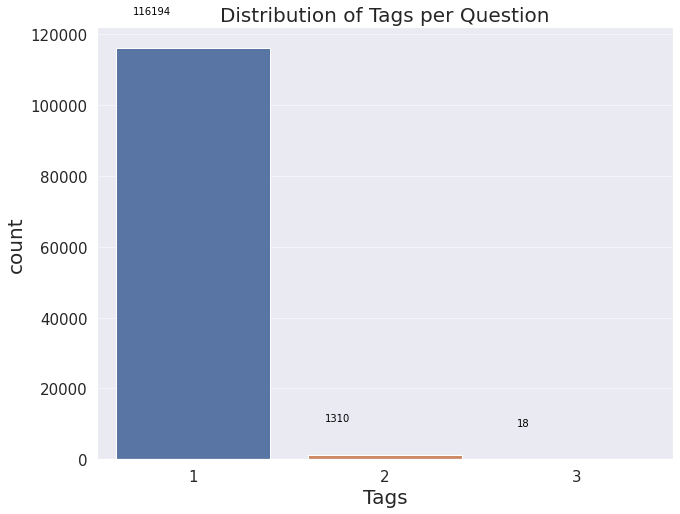

In [57]:
fig = plt.figure(figsize = (8, 6))
axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Distribution of Tags per Question", fontsize = 20)
axes.set_xlabel("Tags", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
plt.grid(linestyle='-', linewidth=0.5)
axes.tick_params(labelsize = 15)
sns.countplot(list(df['tag_count']), ax = axes)
for i in axes.patches:
    axes.text(i.get_x()+0.09, i.get_height()+9500, str(round(i.get_height(), 2)), fontsize=10, color='black')
plt.show()

In [58]:
def plot_boxplot(column):
    plt.style.use('ggplot')
    sns.set_style('whitegrid')
    plt.figure(figsize = (13,15))
    plt.boxplot(x = column, data = df)
    plt.show()  

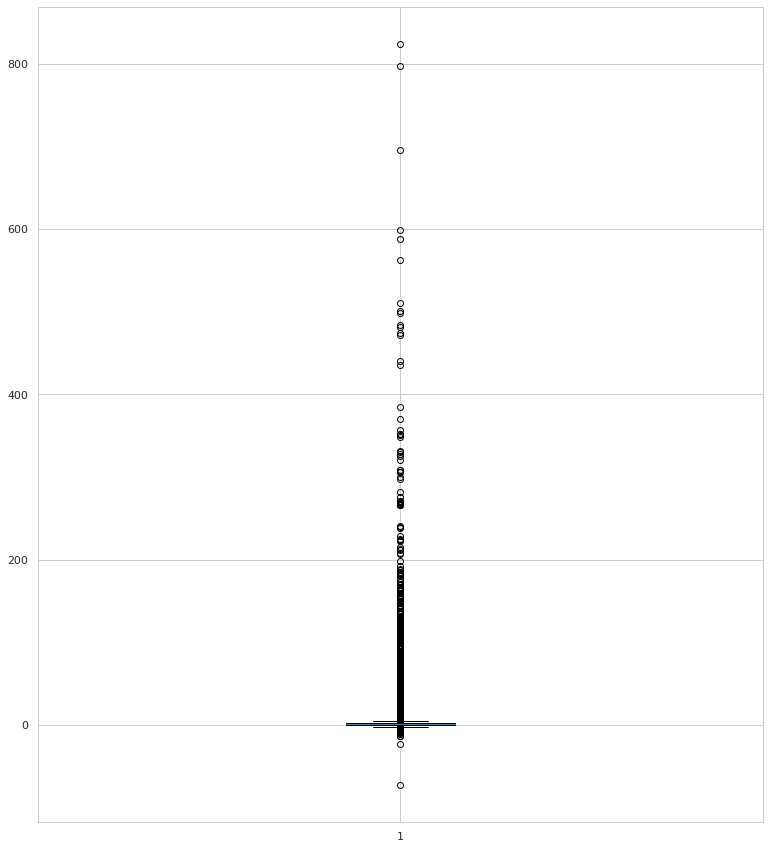

In [59]:
plot_boxplot(df['score_quest'])

In [60]:
percentile = df['score_quest'].quantile(0.955)
percentile

7.0

In [61]:
df['score_quest'][df['score_quest'] > percentile] = percentile

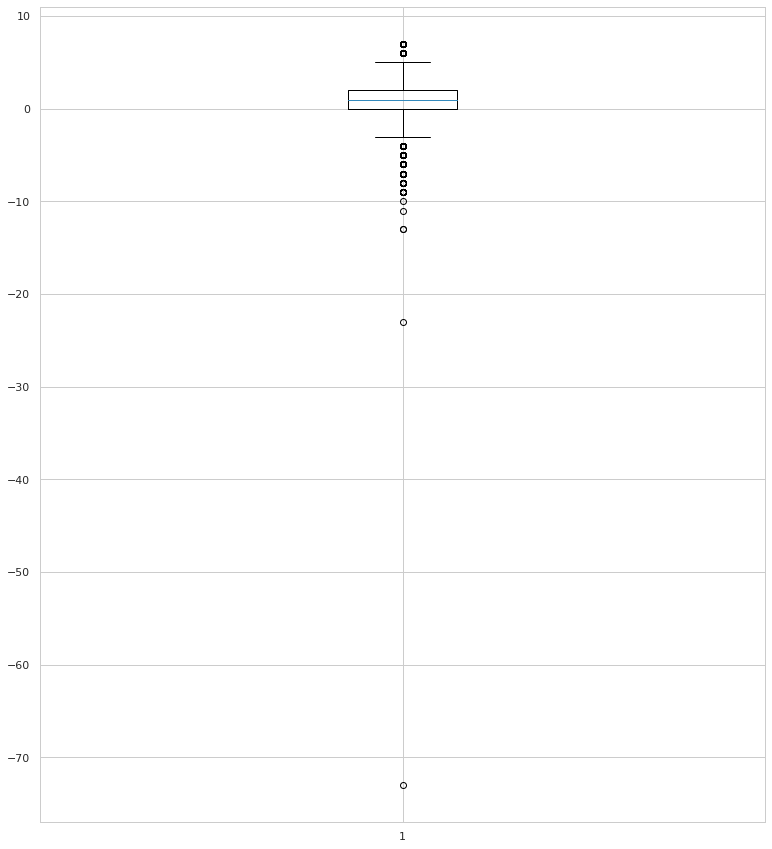

In [62]:
plot_boxplot(df['score_quest'])

In [63]:
percentile = df['score_quest'].quantile(0.050)
percentile

-1.0

In [64]:
df['score_quest'][df['score_quest'] < percentile] = percentile

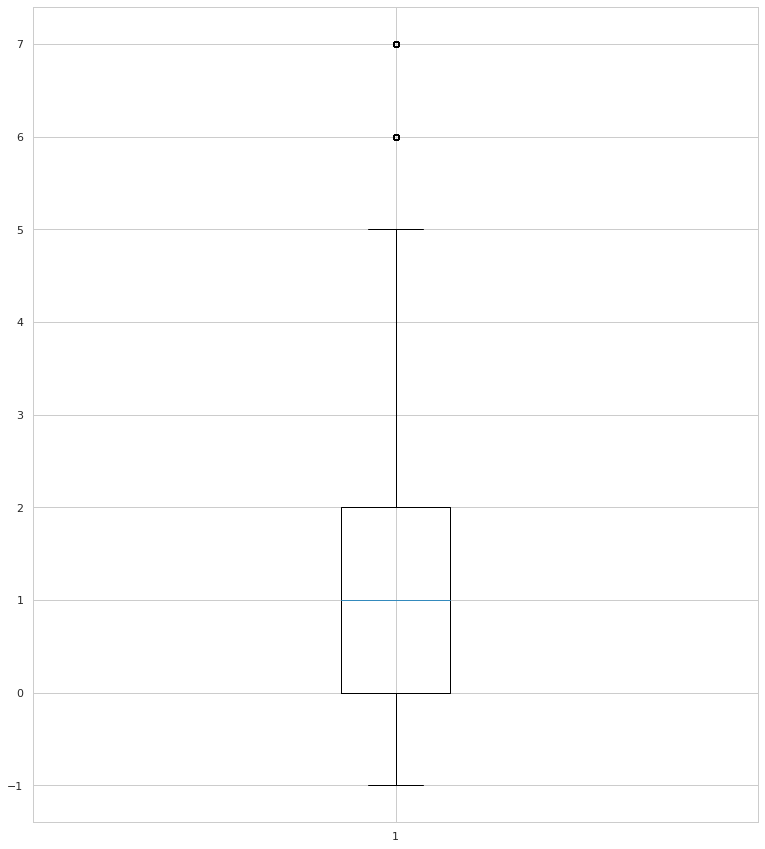

In [65]:
plot_boxplot(df['score_quest'])

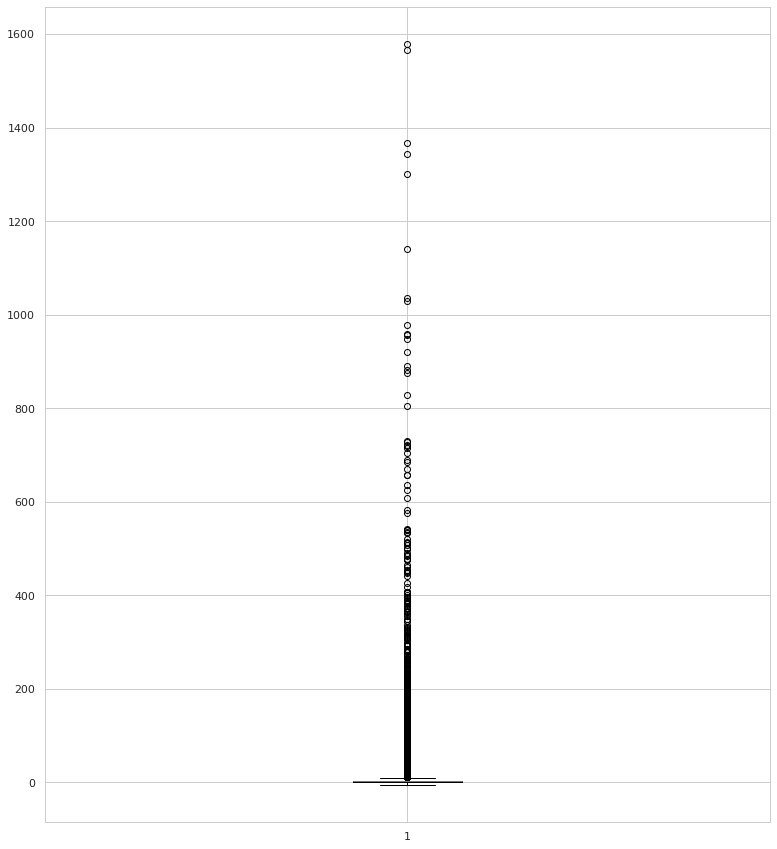

In [66]:
plot_boxplot(df['score_ans'])

In [67]:
percentile = df['score_ans'].quantile(0.955)
percentile

14.0

In [68]:
df['score_ans'][df['score_ans'] > percentile] = percentile

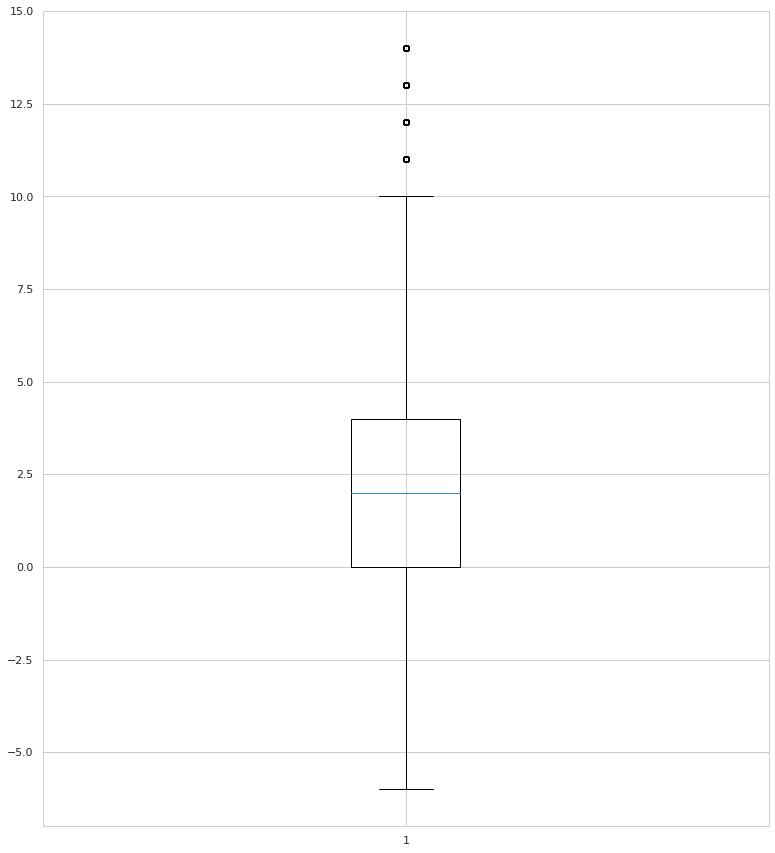

In [69]:
plot_boxplot(df['score_ans'])

In [70]:
df.head()

,id,creationdate,score_quest,title,body_quest,score_ans,body_ans,tags,tag_count
0,120,2008-08-01T15:50:08Z,7,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,9,[<p>The Jeff Prosise version from MSDN magazin...,sql,1
1,1970,2008-08-05T06:39:31Z,7,What language do you use for PostgreSQL trigge...,<p>PostgreSQL is interesting in that it suppor...,14,[<p>When I wrote my first trigger it was in Pe...,sql,1
2,2120,2008-08-05T11:49:11Z,7,Convert HashBytes to VarChar,<p>I want to get the MD5 Hash of a string valu...,14,[<p>I have found the solution else where:</p>\...,sql,1
3,2840,2008-08-05T20:57:00Z,7,Paging SQL Server 2005 Results,<p>How do I page results in SQL Server 2005?</...,14,[<p>You can use <code>the Row_Number()</code> ...,sql,1
4,4110,2008-08-06T23:19:50Z,7,What program can I use to generate diagrams of...,<p>I've been tasked with redesigning part of a...,5,[<P>If you are talking about MS SQL Server tab...,sql,1


In [71]:
df.drop(labels='creationdate',axis=1,inplace=True)

In [72]:
df.isnull().sum()

id             0
score_quest    0
title          0
body_quest     0
score_ans      0
body_ans       0
tags           0
tag_count      0
dtype: int64

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117522 entries, 0 to 117535
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           117522 non-null  int64 
 1   score_quest  117522 non-null  int64 
 2   title        117522 non-null  object
 3   body_quest   117522 non-null  object
 4   score_ans    117522 non-null  int64 
 5   body_ans     117522 non-null  object
 6   tags         117522 non-null  object
 7   tag_count    117522 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 8.1+ MB


#### ***Let's examine the popularity of some common tags used in Data Science***

In [74]:
# 1. How many questions are asked w.r.t number of Tags?

tags = list(df['tags'].unique())
tags

['sql',
 'python',
 'excel',
 'matlab',
 'python sql',
 'r',
 'sql excel',
 'sas',
 'python excel',
 'python r',
 'excel sas',
 'python matlab',
 'sql r',
 'excel matlab',
 'excel r',
 'sql sas',
 'python sas',
 'r matlab',
 'r sas',
 'python r matlab',
 'sql matlab',
 'python excel r',
 'python sql excel',
 'r python',
 'sql excel sas',
 'r excel',
 'python r excel',
 'sql excel matlab',
 'r excel matlab',
 'sql r sas',
 'python sql r',
 'sql r excel']

In [75]:
from tqdm import tqdm_notebook
from collections import Counter
num_tags = []
for tag_ in tqdm_notebook(tags):
    num_tags.append(len(tag_.split(' ')))
num_tags = Counter(num_tags)

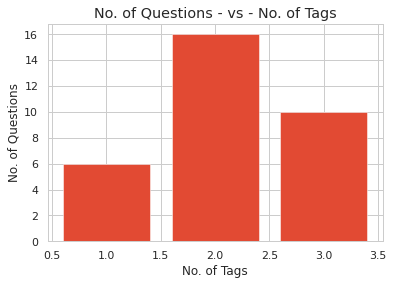

In [76]:
plt.bar(list(num_tags.keys()), list(num_tags.values()))
plt.xlabel('No. of Tags')
plt.ylabel('No. of Questions')
plt.title('No. of Questions - vs - No. of Tags')
plt.show()

Most the questions asked on the platform contain 2 tags, followed by 3 tags, and 1 tags

In [77]:
# 2. How scores of Answers /Questions related to number of tags

view_tags_all  = df[['score_ans','score_quest','tag_count']]
view_tags_all.head()

,score_ans,score_quest,tag_count
0,9,7,1
1,14,7,1
2,14,7,1
3,14,7,1
4,5,7,1


In [79]:
view_tags_all.describe()

,score_ans,score_quest,tag_count
count,117522.00%,117522.00%,117522.00%
mean,2.87%,1.19%,1.01%
std,3.59%,1.93%,0.11%
min,-6.00%,-1.00%,1.00%
25%,0.00%,0.00%,1.00%
50%,2.00%,1.00%,1.00%
75%,4.00%,2.00%,1.00%
max,14.00%,7.00%,3.00%


From the table, we can infer following observations:

1.   A one tag question got very low score.
2.   A three tag question has a answer score of 14

In [80]:
# 3. What tags get highest/lowest rating in Questions?

view_tags = df[['score_quest','tags']].drop_duplicates().reset_index(drop=True)
view_tags.head()

,score_quest,tags
0,7,sql
1,7,python
2,2,python
3,5,sql
4,7,excel


In [81]:
tagRate = {}
for i in tqdm_notebook(range(len(view_tags['tags']))):
    for tag in view_tags['tags'][i].split(','):
        try:
            tagRate[tag].append(view_tags['score_quest'][i])
        except Exception:
            tagRate[tag] = [view_tags['score_quest'][i]]

In [82]:
tagRateAvg = {}
for key in list(tagRate.keys()):
    tagRateAvg[key] = np.average(tagRate[key])

tagRateAvg = pd.DataFrame([list(tagRateAvg.keys()), list(tagRateAvg.values())])
tagRateAvg = tagRateAvg.transpose()
tagRateAvg.columns = ['tags', 'score_quest']
tagRateAvg = tagRateAvg.sort_values('score_quest')

Text(0, 0.5, 'Tag')

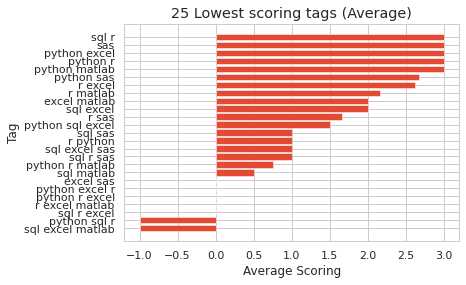

In [83]:
plt.barh(list(tagRateAvg['tags'])[:25], list(tagRateAvg['score_quest'])[:25])
plt.xlabel('Average Scoring')
plt.title('25 Lowest scoring tags (Average)')
plt.ylabel('Tag')

From the Graph, we can infer that combined tags of sql, excel, matlab based questions achieved the lowest scoring followed by python, sql, r.

Text(0, 0.5, 'Tag')

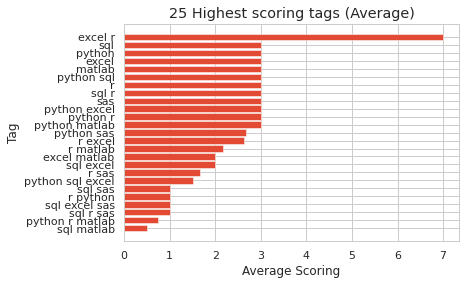

In [84]:
plt.barh(list(tagRateAvg['tags'])[-25:], list(tagRateAvg['score_quest'])[-25:])
plt.xlabel('Average Scoring')
plt.title('25 Highest scoring tags (Average)')
plt.ylabel('Tag')

From the Graph, we can infer that combined tags of excel,r based questions achieved the highest scoring.

In [85]:
# 4. What tags get highest/lowest rating in Answers?

view_tags = df[['score_ans','tags']].drop_duplicates().reset_index(drop=True)
view_tags.head()

,score_ans,tags
0,9,sql
1,14,sql
2,5,sql
3,7,sql
4,12,python


In [86]:
tagRate = {}
for i in tqdm_notebook(range(len(view_tags['tags']))):
    for tag in view_tags['tags'][i].split(','):
        try:
            tagRate[tag].append(view_tags['score_ans'][i])
        except Exception:
            tagRate[tag] = [view_tags['score_ans'][i]]

In [87]:
tagRateAvg = {}
for key in list(tagRate.keys()):
    tagRateAvg[key] = np.average(tagRate[key])

tagRateAvg = pd.DataFrame([list(tagRateAvg.keys()), list(tagRateAvg.values())])
tagRateAvg = tagRateAvg.transpose()
tagRateAvg.columns = ['tags', 'score_ans']
tagRateAvg = tagRateAvg.sort_values('score_ans')

Text(0, 0.5, 'Tag')

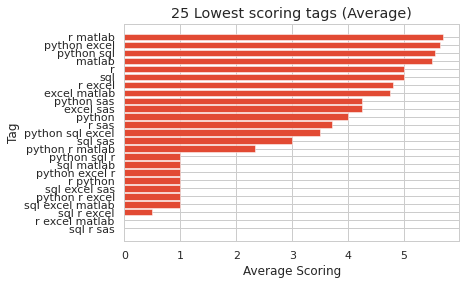

In [88]:
plt.barh(list(tagRateAvg['tags'])[:25], list(tagRateAvg['score_ans'])[:25])
plt.xlabel('Average Scoring')
plt.title('25 Lowest scoring tags (Average)')
plt.ylabel('Tag')

From the Graph, we can infer that combined tags of sql,excel,r based questions achieved the lowest scoring.

Text(0, 0.5, 'Tag')

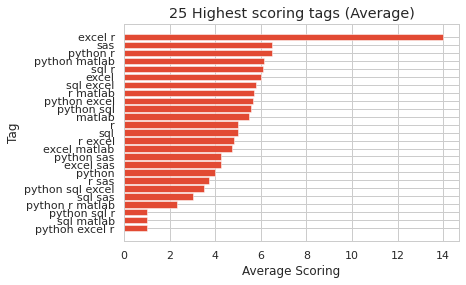

In [89]:
plt.barh(list(tagRateAvg['tags'])[-25:], list(tagRateAvg['score_ans'])[-25:])
plt.xlabel('Average Scoring')
plt.title('25 Highest scoring tags (Average)')
plt.ylabel('Tag')

From the Graph, we can infer that combined tags of excel,r based questions achieved the highest scoring.

In [93]:
# 5. What are the scoring of Data Science related tags in Answers

data_science = ['python', 'r', 'matlab', 'sas', 'excel', 'sql']
x = []
y = []
for tag in data_science:
    index = list(tagRateAvg['tags']).index(tag)
    x.append(tag)
    y.append(list(tagRateAvg['score_ans'])[index])

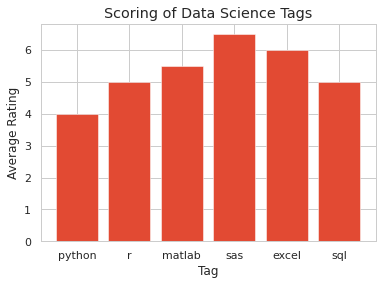

In [94]:
plt.bar(x, y)
plt.ylabel('Average Rating')
plt.xlabel('Tag')
plt.title('Scoring of Data Science Tags')
plt.show()

Text(0.5, 1.0, 'excel')

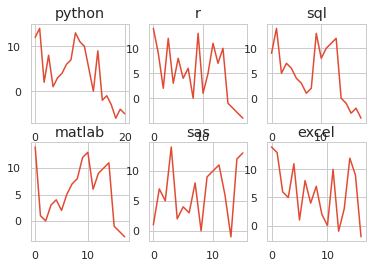

In [95]:
fig, ax = plt.subplots(2, 3)
ax[0][0].plot(tagRate['python'])
ax[0][0].set_title('python')

ax[0][1].plot(tagRate['r'])
ax[0][1].set_title('r')

ax[0][2].plot(tagRate['sql'])
ax[0][2].set_title('sql')

ax[1][0].plot(tagRate['matlab'])
ax[1][0].set_title('matlab')

ax[1][1].plot(tagRate['sas'])
ax[1][1].set_title('sas')

ax[1][2].plot(tagRate['excel'])
ax[1][2].set_title('excel')

In [96]:
# Finding Similar tags

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

tags = []
for tag in list(df['tags']):
    tags.append(tag.split(','))
embedding = Word2Vec(tags, sg=1, size=256, min_count=1)

In [97]:
X = embedding[embedding.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

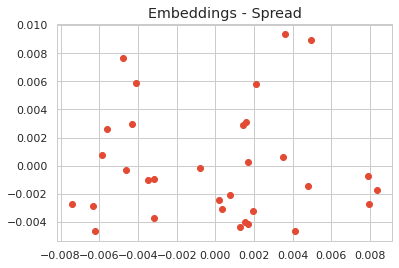

In [98]:

fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Embeddings - Spread')
plt.show()

<Figure size 2160x504 with 0 Axes>

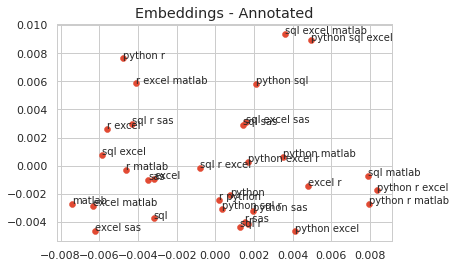

In [99]:
i = 50
plt.figure(figsize=(30,7))
fig, ax = plt.subplots()
ax.set_title('Embeddings - Annotated')
ax.scatter(result[:i, 0], result[:i, 1])

for j, txt in enumerate(list(embedding.wv.vocab)[:i]):
    ax.annotate(txt, result[j])

From the above graph we can notice that terms such as sql,sas / python,excel / pyhon, sas etc occur together which actually makes sense as these tags indicate data science components. 

In [100]:
tag_csv_data = df.to_csv('tags.csv', index = True)

In [102]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
df2 = df[:10000]

In [104]:
df2.to_csv('data2.csv')
!cp data2.csv "drive/My Drive/Colab Notebooks/MLC_B1_C1_Project_AnannyaRoyChowdhury/"

### ***Begin the Analysis from DB perspective***

In [69]:
import sqlite3
import csv
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
import pickle
from sklearn.feature_extraction.text import CountVectorizer

In [70]:
csvfile = pd.read_csv('data2.csv')

In [71]:

csvfile.drop(labels='Unnamed: 0',axis=1,inplace=True)
csvfile.head(10)

,id,score_quest,title,body_quest,score_ans,body_ans,tags,tag_count
0,120,7,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,9,['<p>The Jeff Prosise version from MSDN magazi...,sql,1
1,1970,7,What language do you use for PostgreSQL trigge...,<p>PostgreSQL is interesting in that it suppor...,14,"[""<p>When I wrote my first trigger it was in P...",sql,1
2,2120,7,Convert HashBytes to VarChar,<p>I want to get the MD5 Hash of a string valu...,14,"[""<p>I have found the solution else where:</p>...",sql,1
3,2840,7,Paging SQL Server 2005 Results,<p>How do I page results in SQL Server 2005?</...,14,['<p>You can use <code>the Row_Number()</code>...,sql,1
4,4110,7,What program can I use to generate diagrams of...,<p>I've been tasked with redesigning part of a...,5,"[""<P>If you are talking about MS SQL Server ta...",sql,1
5,6340,7,Multiple foreign keys?,<p>I've got a table that is supposed to track ...,7,"[""<p>You defined the primary key twice. Try:</...",sql,1
6,10190,7,How to return a page of results from SQL?,<p>Many applications have grids that display d...,14,"['<p>On MS SQL Server 2005 and above, <a href=...",sql,1
7,11060,7,How should I unit test a code-generator?,<p>This is a difficult and open-ended question...,12,"[""<p>I started writing up a summary of my expe...",python,1
8,13540,7,Insert Update stored proc on SQL Server,<p>I've written a stored proc that will do an ...,14,"['<p>Your assumption is right, this is the opt...",sql,1
9,17250,7,Create an encrypted ZIP file in Python,<p>I'm creating an ZIP file with ZipFile in Py...,14,"['<p>You can use the <a href=""http://www.chilk...",python,1


In [105]:
#Creating db file from csv
if not os.path.isfile(os.path.join("Dtbsso.db")):
    #this sqlalchemy create_engine creates an in-memory SQLite database.
    engine = create_engine("sqlite:///Dtbsso.db") #https://docs.sqlalchemy.org/en/13/core/engines.html
    chunksize = 150
    cnt = 0
    for rows in pd.read_csv(("data2.csv"),header=None, names = [ "recordid","id", "score_quest", "title", "body_quest","score_ans","body_ans" ,"tags"], chunksize = chunksize, iterator = True):
        cnt+=1
        rows.to_sql('Rows', engine, if_exists='append', index = False)
        if cnt % 1000 == 0:
            print("{} rows written".format(cnt*chunksize))
    
#Here above what we are doing is that, first we have created an in memory sqlite database using the line: 
#"create_engine("sqlite:///"+os.path.join(DATAPATH, DATA_DB))". 
#After this we are reading our csv file in chunks of 150 as an iterator. It simply means that whenever the loop runs we are 
#simply reading 150 rows everytime and appending this 150 rows in the sqlite database created above in the table name "Rows".

In [106]:
# Counting number of rows
if os.path.isfile(os.path.join("Dtbsso.db")):
    connection = sqlite3.connect(os.path.join("Dtbsso.db"))
    data_count = pd.read_sql_query("SELECT * FROM Rows", connection)
    connection.close()
data_count

,recordid,id,score_quest,title,body_quest,score_ans,body_ans,tags
0,id,score_quest,title,body_quest,score_ans,body_ans,tags,tag_count
1,120,7,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,9,['<p>The Jeff Prosise version from MSDN magazi...,sql,1
2,1970,7,What language do you use for PostgreSQL trigge...,<p>PostgreSQL is interesting in that it suppor...,14,"[""<p>When I wrote my first trigger it was in P...",sql,1
3,2120,7,Convert HashBytes to VarChar,<p>I want to get the MD5 Hash of a string valu...,14,"[""<p>I have found the solution else where:</p>...",sql,1
4,2840,7,Paging SQL Server 2005 Results,<p>How do I page results in SQL Server 2005?</...,14,['<p>You can use <code>the Row_Number()</code>...,sql,1
...,...,...,...,...,...,...,...,...
9996,5206910,0,"How to correct "" Subscript indices must either...",<p>I am very new in Matlab. I made a for loop ...,0,"[""<p>well, it's simple. first let's just remov...",matlab,1
9997,5207430,1,non-prime factorings with some repeats,"<p>Let's say we have numbers factors, for exam...",3,['<p>What you are looking for is more commonly...,python,1
9998,5207960,2,How to partition an image to 64 block in matlab,<p>I want to compute the Color Layout Descript...,6,"[""<p>Here some pieces of code that I wrote for...",matlab,1
9999,5208060,1,"Extending auth.User model, proxied fields, and...",<p>(Edit: I know that there's a totally separ...,2,"['<p>This is not a proxy class, it is a relati...",python,1


***Distribution of tags per question***

In [91]:
if os.path.isfile(os.path.join("Dtbsso.db")):
    con = sqlite3.connect(os.path.join("Dtbsso.db"))
    data_tags = pd.read_sql_query("SELECT body_ans FROM Rows", con)
    data_tags_count = data_tags["body_ans"].apply(lambda x: len(x.split(" "))) #series.apply(func) invoke function on values of Series.
    data_tags['tags_count'] = data_tags_count
    data_tags.head()

In [92]:

data_tags['tags_count'].value_counts()

1    9903
2      98
Name: tags_count, dtype: int64

In [93]:
if os.path.isfile(os.path.join("Dtbsso.db")):
    con = sqlite3.connect(os.path.join("Dtbsso.db"))
    data_tags = pd.read_sql_query("SELECT body_ans FROM Rows", con)
    vectorizer = CountVectorizer(tokenizer = lambda x: x.split(" "))
    data_bow = vectorizer.fit_transform(data_tags['body_ans'])
    con.close()

***Number of times Tags appeared in our data***

In [94]:
#top highest occurring tags
col_sum = data_bow.sum(axis = 0).A1 #data_bow.sum(axis = 0) will sum the column of sparse matrix then .A1 will convert that 
                                    #matrix into array.
feat_count = dict(zip(vectorizer.get_feature_names(), col_sum))
feat_count_sorted = dict(sorted(feat_count.items(), key = lambda x: x[1], reverse = True))
count_data = {"Tags":list(feat_count_sorted.keys()), "Count": list(feat_count_sorted.values())}
count_df = pd.DataFrame(data = count_data)
count_df[:10]

,Tags,Count
0,python,4903
1,sql,3935
2,excel,600
3,r,338
4,matlab,296
5,sas,26
6,tags,1


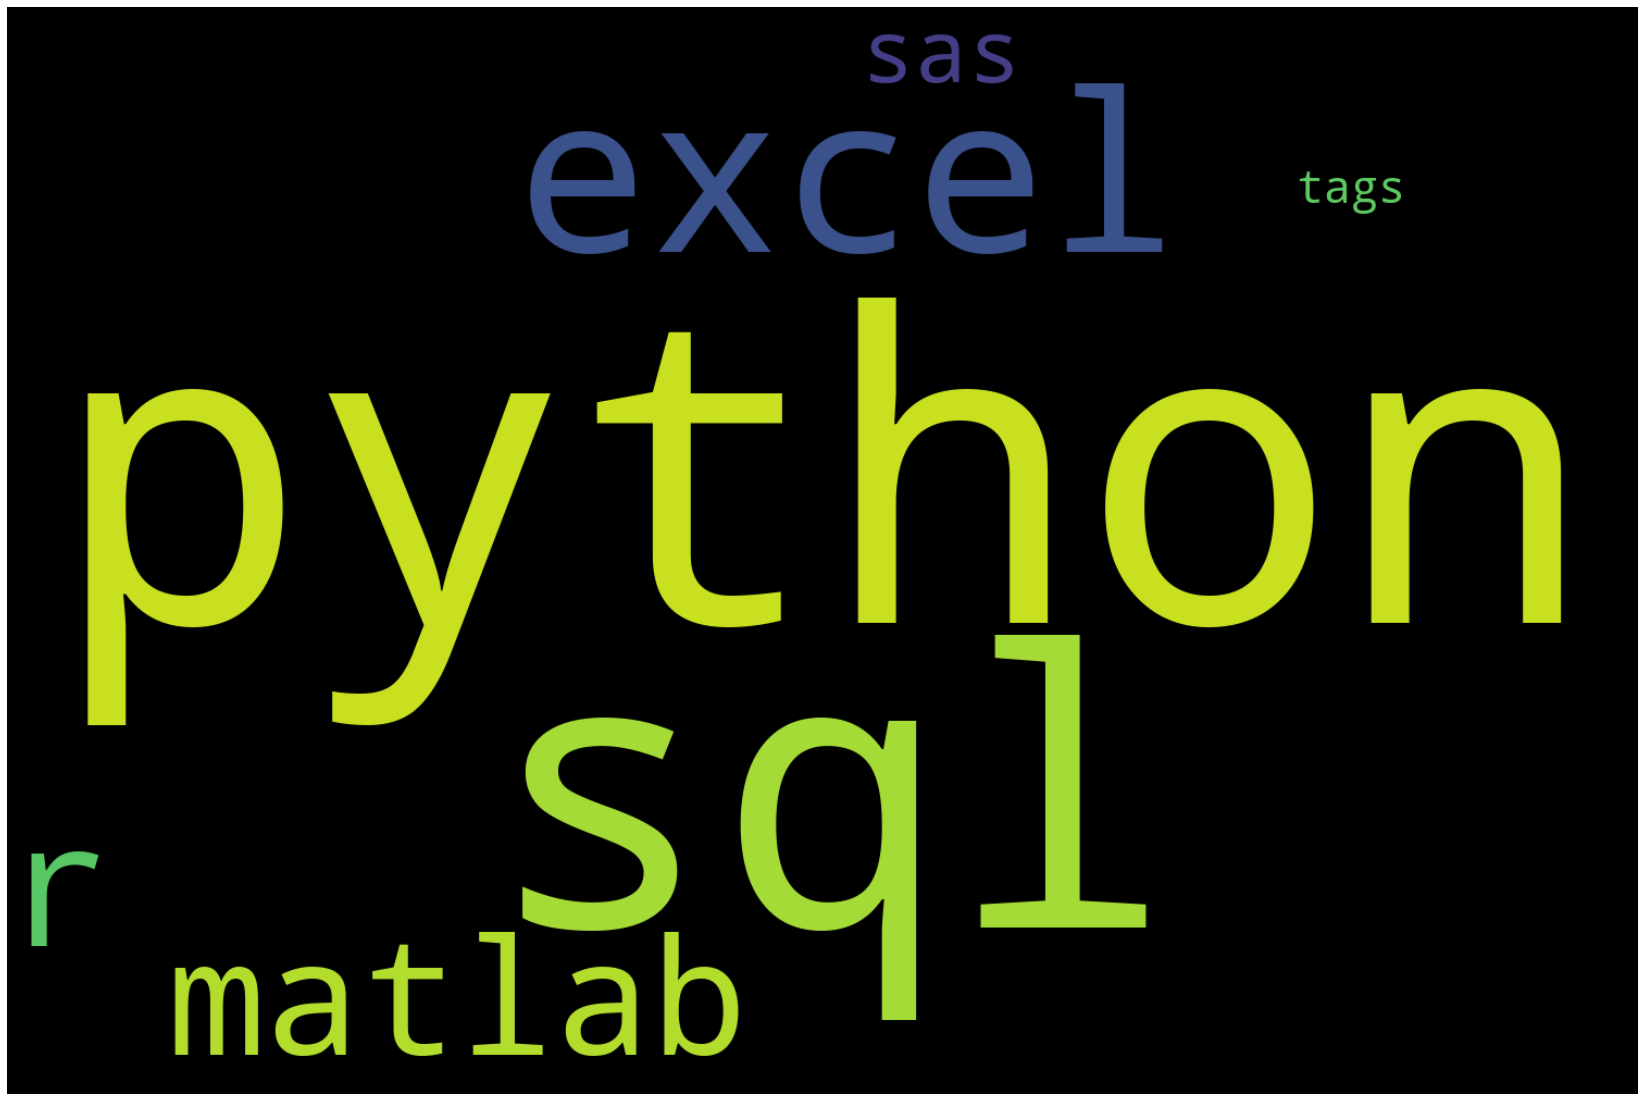

In [96]:
!pip install wordcloud
from wordcloud import WordCloud

worcloudPlot = WordCloud(background_color="black", width=1500, height=1000)
worcloudPlot.generate_from_frequencies(frequencies=feat_count)
plt.figure(figsize=(30,20))
plt.imshow(worcloudPlot, interpolation="bilinear")
plt.axis("off")
plt.show()

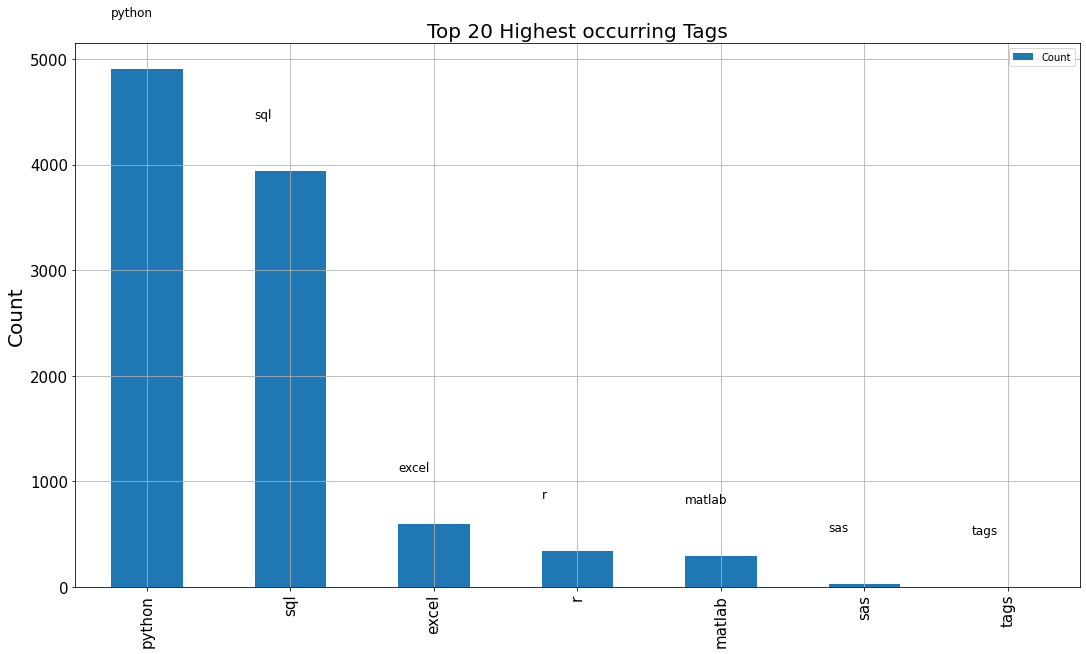

In [102]:
axes = count_df.head(20).plot(x = 'Tags', y = 'Count', kind = 'bar', figsize = (18, 10), fontsize = 15, grid = True)
plt.xlabel("")
plt.ylabel("Count", fontsize = 20)
plt.title("Top 20 Highest occurring Tags", fontsize = 20)
cnt = 0
for i in axes.patches:
    axes.text(i.get_x(), i.get_height()+500, count_df.head(20)['Tags'][cnt], fontsize=12, color='black')
    cnt +=1